# AML 2024  
## CMI Assignment 1 
### Siddhesh Maheshwari MDS202342 <br> Narendra C MDS202336 <br> Gauranga Kumar Baishya MDS202325 
**Due Date: Sep 28, 2024**

### 1) Classifier for Fashion MNIST:
This dataset contains images of 10 types of clothing, shoes, or other material. Your task is to build a classifier for this dataset using CNN.

#### a) Classify each image into one of 3 classes {clothes, shoes and others}.
- i) First label the images in the training and the test dataset using these 3 labels.
- ii) Then, train your neural network to predict one of these 3 labels.
- iii) Finally, show the performance on the test set.

#### b) Show the effect of permuting the image pixels on CNN classifiers, as we saw in the lectures.

**Fashion-MNIST Dataset**: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)


### 2) Build a Resnet-18 classifier for the Emotion Detection Dataset
[https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data)

#### a) First train a classifier from scratch.
*Note: Resnet-18 and other models are built-in PyTorch, and you can use those if you like.*

#### b) Next, fine-tune a pretrained Resnet-18 on this dataset.
As before, PyTorch has a pre-trained Resnet-18 built-in.

#### c) For both cases, show the performance on the Test set, and compare results.

#### d) Note that Resnet expects images to have a size of 224x224 pixels, and color.
You have to pre-process the images in the dataset accordingly.

### Instructions:
- You have to submit a jupyter notebook (`.ipynb`) with all your code and outputs of the code.
- You have to submit a 1-page writeup documenting what you have done.
- You have to upload these files on Moodle, so make sure they are not larger than 8MB.
- Contact the TAs if you face any issues.
- If you don’t include the outputs in the `.ipynb`, you will get partial credit.
- You can work in groups of 2 or 3.
- Only one member of the group should submit the assignment.
- Please mention the names and roll-numbers of all group members.
- You are free to build upon examples shown in class.
- Please check and confirm with the TAs that your submission has been received on time and there are no issues with the uploaded file.
- No requests for re-submitting the assignment later because of any reason will be accepted after the due date.


# Part-1 Classifier for Fashion MNIST:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import random

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Without Data Augmentation

### Load the FashionMNIST dataset and relabel
Observe that we set shuffle=True, which means that data is randomized

## a) Classify each image into one of 3 classes {clothes, shoes and others}.


###- i) First label the images in the training and the test dataset using these 3 labels.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 3     # there are 10 classes

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
             }
new_labels_map = {
    0: "Clothes",  # Grouped original labels [0, 1, 2, 3, 4, 6]
    1: "Shoes",    # Grouped original labels [7, 9]
    2: "Others"    # Grouped original labels [5, 8]
}

# Custom mapping function for new labels
def map_labels(original_label):
    if original_label in [0, 1, 2, 3, 4, 6]:  # 0 ----> "clothes"
        return 0
    elif original_label in [5,7,9]:             # 1 ----> "shoes"
        return 1
    else:                                     # 2 ----> "others"
        return 2

# Custom dataset class to override the labels
class CustomFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, original_label = self.dataset[idx]
        new_label = map_labels(original_label)
        return image, new_label

# Set up data loaders with the custom dataset
train_loader = torch.utils.data.DataLoader(CustomFashionMNIST('../data', train=True, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size=600, shuffle=True)

test_loader = torch.utils.data.DataLoader(CustomFashionMNIST('../data', train=False, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size=10000, shuffle=True)


Ploting some items from train set

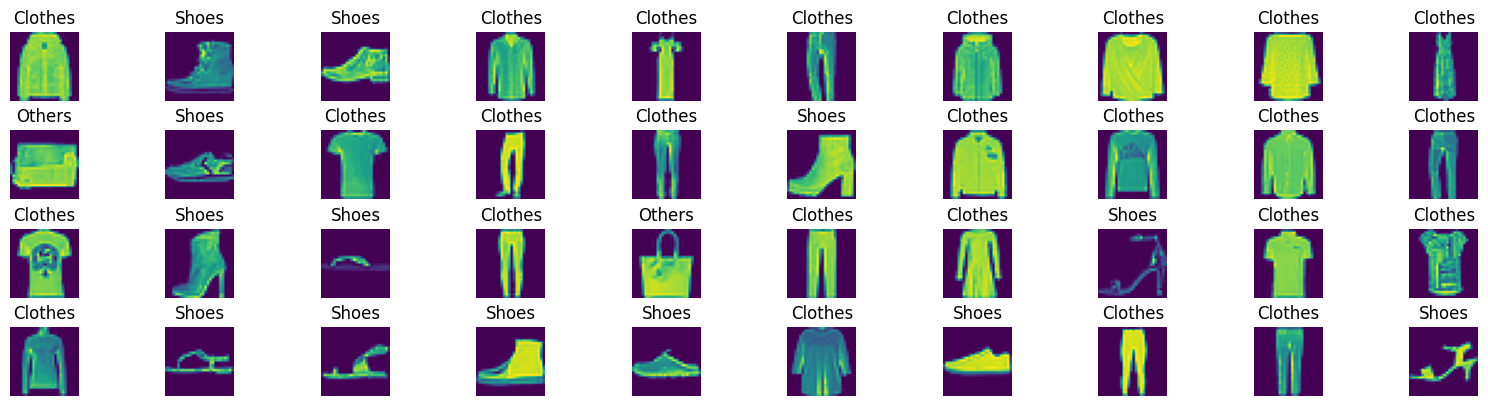

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(40):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(4, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(new_labels_map[label])

plt.tight_layout(pad=0.5)  # Adjust pad to control spacing between subplots
plt.show()

In [ ]:
image_batch, label_batch = next(iter(train_loader))
label_batch[:10]

tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
len(train_loader.dataset),len(test_loader.dataset)

(60000, 10000)

### Helper functions for training and testing

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list_1 = []
loss_list_1 = []

# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_list_1.append(test_loss)
    accuracy_list_1.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## CNN
defining CNN model

### - ii) Then, train your neural network to predict one of these 3 labels.

### Train the network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self,input_size, output_size=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)  # (28, 28, 1) -> (28, 28, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)  # (28, 28, 32) -> (28, 28, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # (28, 28, 32) -> (14, 14, 32)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # (14, 14, 32) -> (14, 14, 64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # (14, 14, 64) -> (14, 14, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (14, 14, 64) -> (7, 7, 64)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Input size based on previous layers
        self.bn = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, output_size)  # Output for 3 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
print("Training on ", device)
accuracy_list_1 = []
loss_list_1 = []
model_cnn = CNN(input_size, output_size=3)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(11):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 1690595
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.167677
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.163851
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.101627
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.088835
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.082283
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.064881
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.066853
Train Epoch: 0 [42000/60000 (70%)]	Loss: 0.057824
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.065384
Train Epoch: 0 [54000/60000 (90%)]	Loss: 0.061055

Test set: Average loss: 0.0443, Accuracy: 9868/10000 (99%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.029203
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.030607
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.026221
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.065155
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.045263
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.029138
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.046957
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.044059
T

In [ ]:
import matplotlib.pyplot as plt
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(4,8), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])

    ax2.barh(numpy.arange(3), pred_prob)
    ax2.set_aspect(0.2)
    ax2.set_yticks(numpy.arange(3))
    ax2.set_yticklabels(numpy.arange(3))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



def plot_accuracy_and_loss(accuracy_list, loss_list):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Plot Accuracy
    ax1.plot(accuracy_list, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8, label='Accuracy')
    # Create a second y-axis for Loss
    ax2 = ax1.twinx()
    ax2.plot(loss_list, marker='o', linestyle='-', color='tomato', linewidth=2, markersize=8, label='Loss')

    # Title
    plt.title("Accuracy and Loss over Epochs", fontsize=16, fontweight='bold')
    fig.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

### - iii) Finally, show the performance on the test set.

In [ ]:
model_cnn.to(device)
test(model_cnn)


Test set: Average loss: 0.0167, Accuracy: 9951/10000 (100%)



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_cnn(data)
        pred = output.data.max(1, keepdim=True)[1]
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

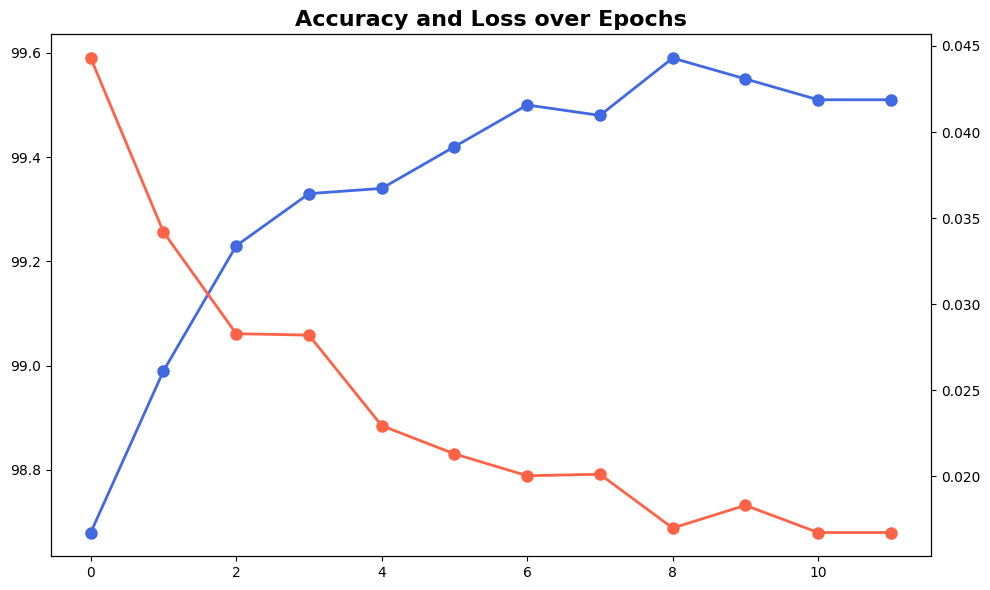

In [ ]:
plot_accuracy_and_loss(accuracy_list_1, loss_list_1)

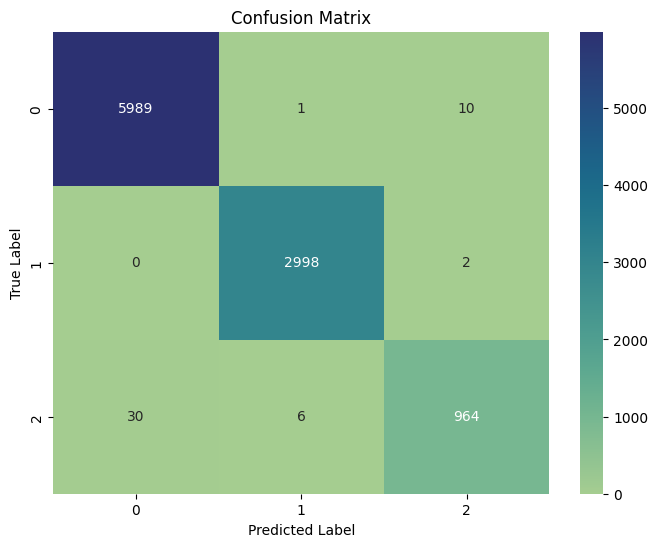

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       1.00      1.00      1.00      3000
           2       0.99      0.96      0.98      1000

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Printing classification report
print(classification_report(y_true, y_pred))

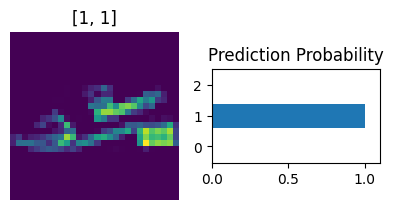

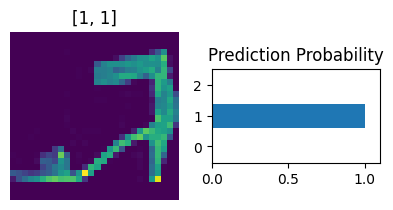

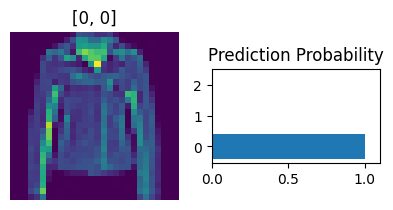

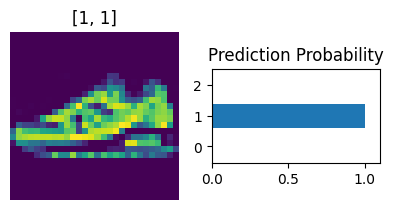

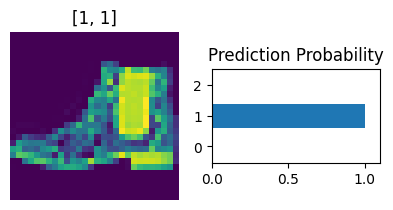

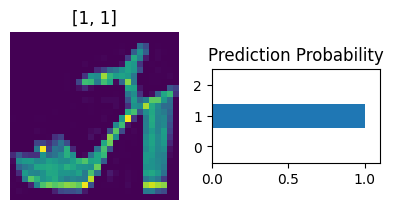

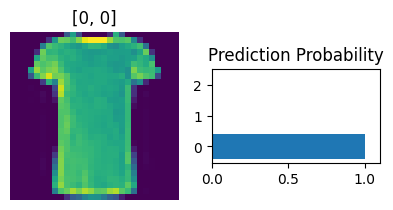

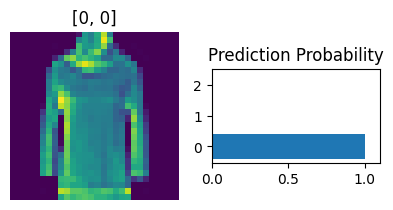

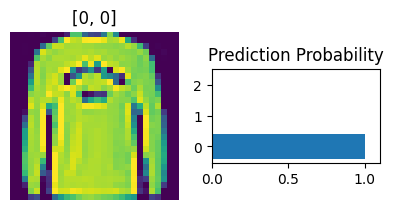

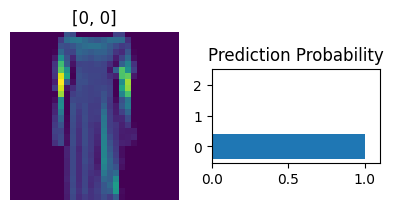

In [ ]:
model_cnn.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)

for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## b) Show the effect of permuting the image pixels on CNN classifiers, as we saw in the lectures.

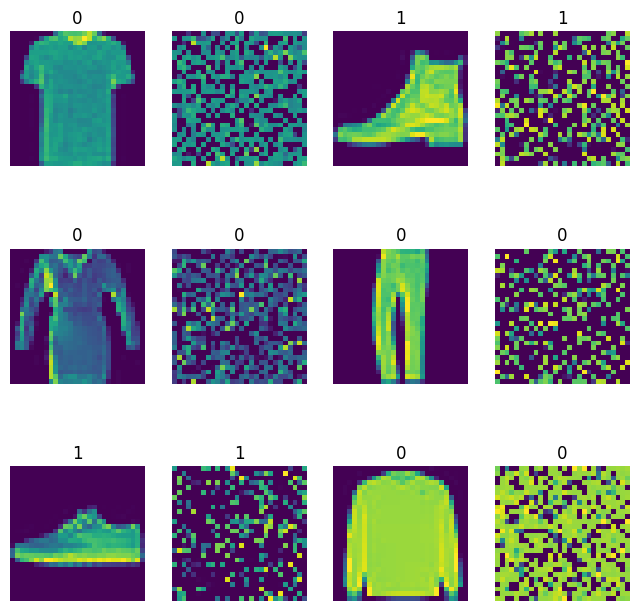

In [ ]:
torch.manual_seed(99)
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [ ]:
accuracy_list_2 = []
loss_list_2 = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    loss_list_2.append(test_loss)
    accuracy_list_2.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
print("Training on ", device)
accuracy_list_2, loss_list_2=[],[]
model_cnn_2 = CNN(input_size, output_size)
model_cnn_2.to(device)
optimizer = optim.SGD(model_cnn_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_2)))

for epoch in range(11):
    scramble_train(epoch, model_cnn_2, fixed_perm)
    scramble_test(model_cnn_2, fixed_perm)

Training on  cuda:0
Number of parameters: 1690595
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.293721
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.447961
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.171989
Train Epoch: 0 [18000/60000 (30%)]	Loss: 0.113278
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.097235
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.084144
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.115776
Train Epoch: 0 [42000/60000 (70%)]	Loss: 0.085738
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.097138
Train Epoch: 0 [54000/60000 (90%)]	Loss: 0.052682

Test set: Average loss: 0.0753, Accuracy: 9784/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.058469
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.065171
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.070846
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.048260
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.046844
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.065182
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.068192
Train Epoch: 1 [42000/60000 (70%)]	Loss: 0.063910
T

the effect of permuting the image pixels on CNN classifiers:

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_cnn_2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, fixed_perm]
        data = data.view(-1, 1, 28, 28)
        output = model_cnn_2(data)
        pred = output.data.max(1, keepdim=True)[1]
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())


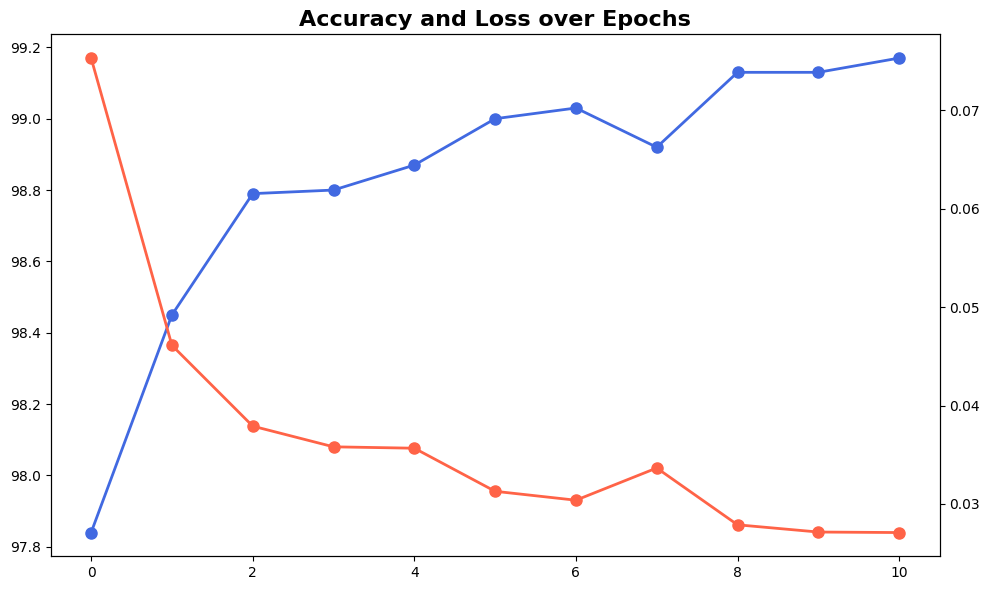

In [ ]:
plot_accuracy_and_loss(accuracy_list_2, loss_list_2)

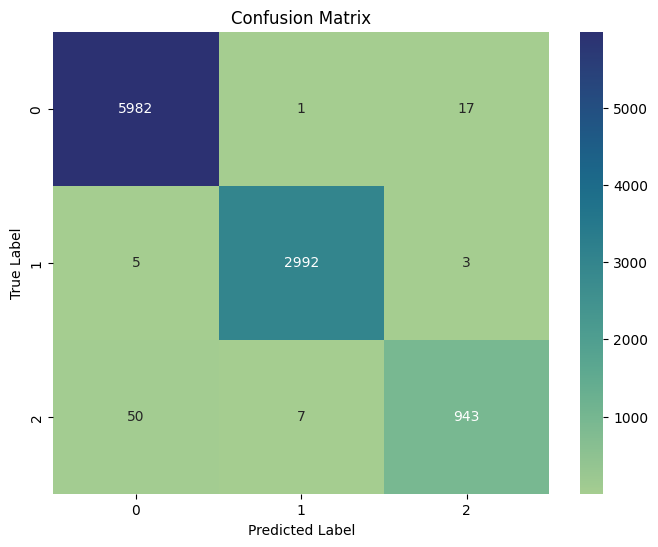

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6000
           1       1.00      1.00      1.00      3000
           2       0.98      0.94      0.96      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Printing classification report
print(classification_report(y_true, y_pred))